# DVS from file

This example demonstrates how to load pre-recorded Dynamic Vision Sensor (DVS) event
data from a file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import ArtistAnimation

%matplotlib inline

import nengo
import nengo_loihi

# All NengoLoihi models should call this before model construction
nengo_loihi.set_defaults()

rng = np.random.RandomState(0)

## Generate synthetic data

Rather than using real DVS data, we will generate some synthetic data and save it in a
`.events` file. In most applications, this will not be necessary, since you will already
have a `.events` or `.aedat` file from a real DVS camera.

In [2]:
def jitter_time(n, t, jitter, rng, dtype="<u4"):
    assert jitter >= 0
    assert t - jitter >= 0
    tt = (t - jitter) * np.ones(n, dtype=dtype)
    if jitter > 0:
        tt += rng.randint(0, 2 * jitter + 1, size=tt.shape, dtype=dtype)
    return tt


# the height and width of the DVS sensor
dvs_height = 180
dvs_width = 240

# our timestep in microseconds (μs)
dt_us = 1000

# the maximum amount by which to jitter spikes around the timestep (in microseconds)
t_jitter_us = 100

assert t_jitter_us < dt_us // 2

# the length of time to generate data for, in seconds and in microseconds
t_length = 1.0
t_length_us = int(1e6 * t_length)

# the maximum rate of input spikes (per pixel)
max_rate = 10
max_prob = max_rate * 1e-6 * dt_us

# the period of the sine wave, in pixels
period = 120

# these functions control the angle (theta) and phase of the sine wave over time
theta_fn = lambda t: 1
phase_fn = lambda t: 10 * t

X, Y = np.meshgrid(np.linspace(-1, 1, dvs_width), np.linspace(-1, 1, dvs_height))

events = []
for t_us in range(dt_us, t_length_us + 1, dt_us):
    t = t_us * 1e-6
    theta = theta_fn(t)
    phase = phase_fn(t)

    X1 = np.cos(theta) * X + np.sin(theta) * Y

    x = np.linspace(-1.5, 1.5, 50)
    prob = np.sin((np.pi * dvs_height / period) * x + phase) * max_prob
    prob = np.interp(X1, x, prob)

    u = rng.rand(*prob.shape)
    s_on = u < prob
    s_off = u < -prob

    y, x = s_off.nonzero()
    tt = jitter_time(len(x), t_us, t_jitter_us, rng, dtype="<u4")
    events.append((tt, 0, x, y))

    y, x = s_on.nonzero()
    tt = jitter_time(len(x), t_us, t_jitter_us, rng, dtype="<u4")
    events.append((tt, 1, x, y))

dvs_events = nengo_loihi.dvs.DVSEvents()
dvs_events.init_events(n_events=sum(len(xx) for _, _, xx, _ in events))

i = 0
for tt, p, xx, yy in events:
    ee = dvs_events.events[i : i + len(xx)]
    ee["t"] = tt
    ee["p"] = p
    ee["x"] = xx
    ee["y"] = yy
    i += len(xx)

events_file_name = "dvs-from-file-events.events"
dvs_events.write_file(events_file_name)
print("Wrote %r" % events_file_name)
del dvs_events

Wrote 'dvs-from-file-events.events'


We can view the data by using the `DVSEvents` class to load the events, group the events
into frames, and then make the frames into a video with the help of Matplotlib's
animation support.

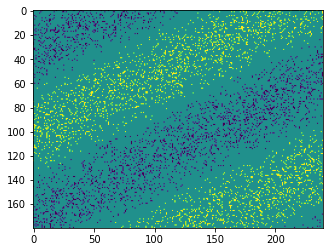

In [3]:
dvs_events = nengo_loihi.dvs.DVSEvents.from_file(events_file_name)

dt_frame_us = 20e3
t_frames = dt_frame_us * np.arange(int(round(t_length_us / dt_frame_us)))

fig = plt.figure()
imgs = []
for t_frame in t_frames:
    t0_us = t_frame
    t1_us = t_frame + dt_frame_us
    t = dvs_events.events[:]["t"]
    m = (t >= t0_us) & (t < t1_us)
    events_m = dvs_events.events[m]

    # show "off" (0) events as -1 and "on" (1) events as +1
    events_sign = 2.0 * events_m["p"] - 1

    frame_img = np.zeros((dvs_height, dvs_width))
    frame_img[events_m["y"], events_m["x"]] = events_sign

    img = plt.imshow(frame_img, vmin=-1, vmax=1, animated=True)
    imgs.append([img])

del dvs_events

ani = ArtistAnimation(fig, imgs, interval=50, blit=True)
HTML(ani.to_html5_video())

## Nengo network

We can now load our data into a NengoLoihi network, using the
`nengo_loihi.dvs.DVSFileChipProcess` type of `nengo.Process`.
When run in a `nengo_loihi.Simulator`,
this process passes the DVS events read from the file
directly to the Loihi board.
It can also be used in a `nengo.Simulator`,
in case you want to prototype your DVS networks in core Nengo first.

We pass the process the path to our data file.
We also use the optional `pool` parameter to pool over space.
This allows our node to output at a lower spatial resolution
than the standard 180 x 240 pixel DVS output.
This can allow for a smaller network for processing the DVS data, and thus
conserve Loihi resources. Note that when we connect the pooled input to the ensembles,
we scale by an input factor of ``1 / np.prod(pool)``; the result is that our pooling
averages over the input events, rather than simply summing them. This is not necessary,
but can make it easier to keep network parameters within typical ranges (akin to
normalizing ``Node`` outputs so that they are in the range ``[-1, 1]``, though in
the case of DVS events, having more than one event per pixel within a simulator timestep
can still result in values outside this range).

We then make two ensembles: one to receive the positive polarity "on" events,
and the other to receive the negative polarity "off" events. Since we passed
`channels_last=True` to our node, the polarity will be the least-significant index of
our node output, and we connect it to the ensembles accordingly (by sending all even
outputs to the negative polarity ensemble `ensembles[0]`, and the odd outputs to the
positive polarity ensemble `ensembles[1]`). We run the simulation and collect the spikes
from both the negative and positive polarity ensembles.

In [4]:
pool = (10, 10)

gain = 101

with nengo.Network() as net:
    dvs_process = nengo_loihi.dvs.DVSFileChipProcess(
        file_path=events_file_name, pool=pool, channels_last=True
    )
    u = nengo.Node(dvs_process)

    ensembles = [
        nengo.Ensemble(
            dvs_process.height * dvs_process.width,
            1,
            neuron_type=nengo.SpikingRectifiedLinear(),
            gain=nengo.dists.Choice([gain]),
            bias=nengo.dists.Choice([0]),
        )
        for _ in range(dvs_process.polarity)
    ]

    for k, e in enumerate(ensembles):
        u_channel = u[k :: dvs_process.polarity]
        nengo.Connection(u_channel, e.neurons, transform=1.0 / np.prod(pool))

    probes = [nengo.Probe(e.neurons) for e in ensembles]

with nengo_loihi.Simulator(net) as sim:
    sim.run(t_length)

sim_t = sim.trange()
shape = (len(sim_t), dvs_process.height, dvs_process.width)
output_spikes_neg = sim.data[probes[0]].reshape(shape) * sim.dt
output_spikes_pos = sim.data[probes[1]].reshape(shape) * sim.dt

We can plot individual frames by collecting spikes near particular points in time.
However, it is much easier to see how the output changes over time when we plot it as a
video.

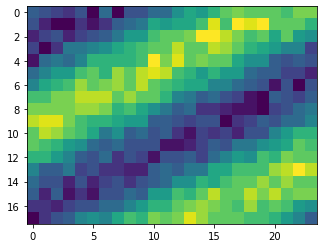

In [5]:
dt_frame = 0.01
t_frames = dt_frame * np.arange(int(round(t_length / dt_frame)))

fig = plt.figure()
imgs = []
for t_frame in t_frames:
    t0 = t_frame
    t1 = t_frame + dt_frame
    m = (sim_t >= t0) & (sim_t < t1)

    frame_img = np.zeros((dvs_process.height, dvs_process.width))
    frame_img -= output_spikes_neg[m].sum(axis=0)
    frame_img += output_spikes_pos[m].sum(axis=0)
    frame_img = frame_img / np.abs(frame_img).max()

    img = plt.imshow(frame_img, vmin=-1, vmax=1, animated=True)
    imgs.append([img])

ani = ArtistAnimation(fig, imgs, interval=50, blit=True)
HTML(ani.to_html5_video())

We see that the output of the NengoLoihi network is qualitatively similar to the input
DVS events we plotted above. This is what we would expect, since the network is not
performing any significant computation, but simply relaying its input to its output. The
key difference is that the resolution of the network output is much lower; this is
because we perform pooling on the DVS data when inputting it to the network, so that the
network is processing everything at the reduced resolution.